In [27]:
# Set random seeds for reproducibility
import numpy as np
import random
np.random.seed(42)
random.seed(42)

# Train a machine learning model on the preprocessed data
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import os

# Paths
DATA_DIR = '../data/'
MODEL_DIR = '../models/'
X_TRAIN_FILE = os.path.join(DATA_DIR, 'X_train.csv')
Y_TRAIN_FILE = os.path.join(DATA_DIR, 'y_train.csv')
X_VAL_FILE = os.path.join(DATA_DIR, 'X_val.csv')
Y_VAL_FILE = os.path.join(DATA_DIR, 'y_val.csv')

# Check if data files exist
for file_path in [X_TRAIN_FILE, Y_TRAIN_FILE, X_VAL_FILE, Y_VAL_FILE]:
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Required file not found: {file_path}")

# Load data
print('Loading data...')
X_train = pd.read_csv(X_TRAIN_FILE)
y_train = pd.read_csv(Y_TRAIN_FILE).values.ravel()
X_val = pd.read_csv(X_VAL_FILE)
y_val = pd.read_csv(Y_VAL_FILE).values.ravel()
print('Data loaded.')

Loading data...
Data loaded.


### Oversample the Minority Class with SMOTE

If your model is still missing 'Satan' attacks, you can use SMOTE to synthetically oversample the minority class in your training data. This can help the model learn to recognize rare attacks more effectively.

In [28]:
# Install imbalanced-learn if not already installed
%pip install -q imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [29]:
from imblearn.over_sampling import SMOTE
import numpy as np

# Determine the minimum number of samples in any class
(unique, counts) = np.unique(y_train, return_counts=True)
min_class_count = counts.min()

# Remove classes with less than 2 samples (SMOTE cannot handle them)
classes_to_keep = unique[counts >= 2]
mask = np.isin(y_train, classes_to_keep)
X_train_smote = X_train[mask]
y_train_smote = y_train[mask]

# Set k_neighbors to min_class_count - 1, but at least 1
if len(counts[counts >= 2]) > 0:
    min_class_count_smote = counts[counts >= 2].min()
    k_neighbors = max(1, min_class_count_smote - 1)
else:
    raise ValueError("No class has at least 2 samples for SMOTE.")

print(f"Applying SMOTE with k_neighbors={k_neighbors}...")
smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
X_train_res, y_train_res = smote.fit_resample(X_train_smote, y_train_smote)

print('Original training set shape:', X_train.shape)
print('Filtered training set shape:', X_train_smote.shape)
print('Resampled training set shape:', X_train_res.shape)
print(f"Used k_neighbors={k_neighbors} for SMOTE (minimum class count: {min_class_count})")

Applying SMOTE with k_neighbors=1...


/Users/saig/AI-Intrusion-Detection-System/venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Original training set shape: (100778, 41)
Filtered training set shape: (100777, 41)
Resampled training set shape: (1186262, 41)
Used k_neighbors=1 for SMOTE (minimum class count: 1)


Training Random Forest...
Evaluating on validation set...
Validation Accuracy: 0.9980
Classification Report:
                 precision    recall  f1-score   support

           back       1.00      1.00      1.00       185
buffer_overflow       1.00      0.33      0.50         9
   guess_passwd       1.00      0.91      0.95        11
           imap       1.00      1.00      1.00         1
        ipsweep       0.99      0.99      0.99       733
           land       0.50      0.67      0.57         3
        neptune       1.00      1.00      1.00      8228
           nmap       0.98      0.98      0.98       313
         normal       1.00      1.00      1.00     13422
           perl       0.00      0.00      0.00         1
            phf       1.00      1.00      1.00         1
            pod       1.00      0.93      0.96        43
      portsweep       1.00      1.00      1.00       573
        rootkit       0.00      0.00      0.00         1
          satan       1.00      0.9

/Users/saig/AI-Intrusion-Detection-System/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/saig/AI-Intrusion-Detection-System/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/saig/AI-Intrusion-Detection-System/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

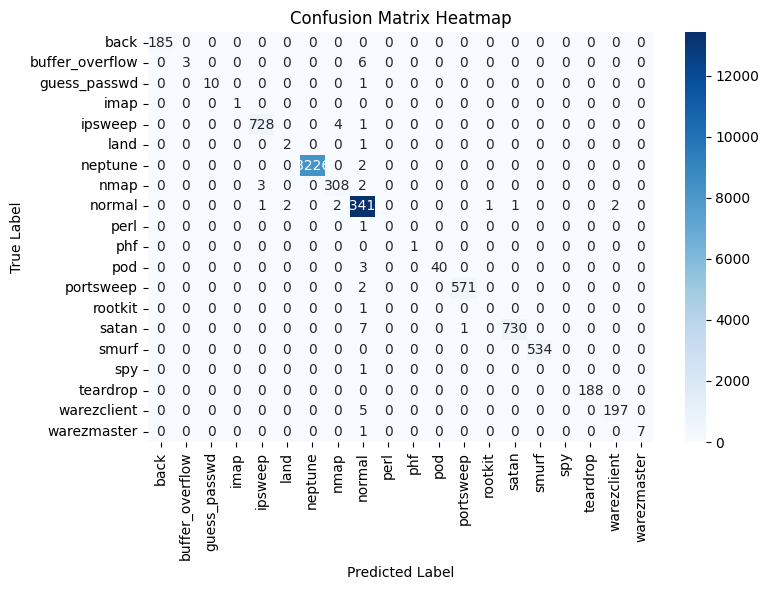

Trained model saved to ../models/random_forest_model.joblib


In [30]:
# Initialize and train model (Random Forest as example)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print('Training Random Forest...')
clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
clf.fit(X_train_res, y_train_res)

# Evaluate on validation set
print('Evaluating on validation set...')
y_pred = clf.predict(X_val)
acc = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {acc:.4f}")
print("Classification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
# Get sorted unique labels from both y_val and y_pred
labels = sorted(list(set(y_val) | set(y_pred)))
cm = confusion_matrix(y_val, y_pred, labels=labels)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Save the trained model
os.makedirs(MODEL_DIR, exist_ok=True)
model_path = os.path.join(MODEL_DIR, 'random_forest_model.joblib')
joblib.dump(clf, model_path)
print(f"Trained model saved to {model_path}")

### Hyperparameter Tuning with GridSearchCV

Let's use GridSearchCV to find the best hyperparameters for the Random Forest model after SMOTE oversampling.

Starting GridSearchCV...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.9min
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.9min
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.9min
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 1.9min
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 1.9min
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 1.9min
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 3.7min
[CV] END class_weight=balanced, 

/Users/saig/AI-Intrusion-Detection-System/venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END class_weight=balanced, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.9min
[CV] END class_weight=balanced, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.9min
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time= 4.2min
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time= 4.3min
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 4.3min
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 4.3min
[CV] END class_weight=balanced, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 3.5min
[CV] END class_weight=balanced, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 3.5min


/Users/saig/AI-Intrusion-Detection-System/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/saig/AI-Intrusion-Detection-System/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/saig/AI-Intrusion-Detection-System/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

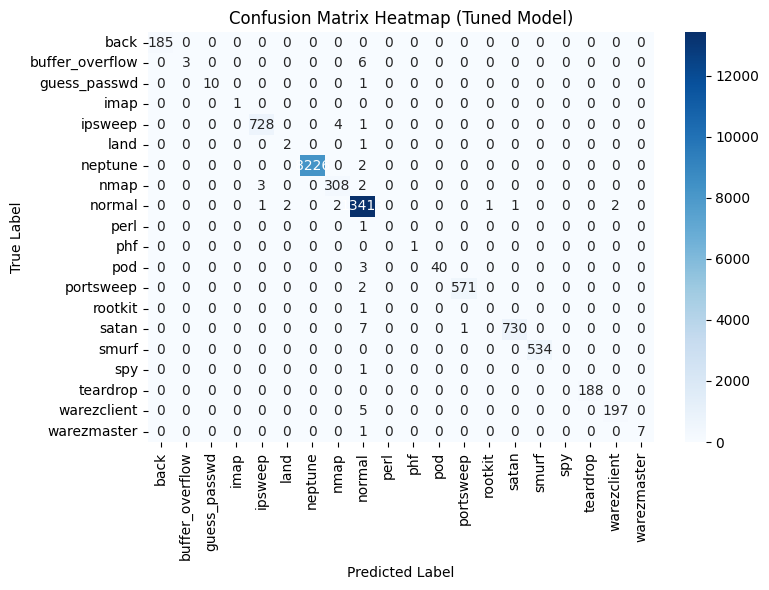

Tuned model saved to ../models/random_forest_model_tuned.joblib


In [31]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced']
}

rf = RandomForestClassifier(random_state=42)
print('Starting GridSearchCV...')
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=2)
grid_search.fit(X_train_res, y_train_res)

print('Best parameters found:', grid_search.best_params_)
print('Best cross-validated score:', grid_search.best_score_)

# Use the best estimator for evaluation
best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_val)
acc = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {acc:.4f}")
print("Classification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
import matplotlib.pyplot as plt
import seaborn as sns
labels = sorted(list(set(y_val) | set(y_pred)))
cm = confusion_matrix(y_val, y_pred, labels=labels)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix Heatmap (Tuned Model)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Save the tuned model
import joblib
import os
os.makedirs(MODEL_DIR, exist_ok=True)
model_path = os.path.join(MODEL_DIR, 'random_forest_model_tuned.joblib')
joblib.dump(best_clf, model_path)
print(f"Tuned model saved to {model_path}")

## Workflow Complete

- Data loaded and checked.
- SMOTE oversampling applied to handle class imbalance.
- Random Forest trained and evaluated.
- Hyperparameter tuning performed with GridSearchCV.
- Both base and tuned models saved to disk.

You can now proceed to test the model on new data or integrate it into your intrusion detection pipeline.

## Predict on New Data

This cell demonstrates how to load the tuned model and make predictions on new data (e.g., `kdd_test_processed.csv`). Update the test file path as needed.

In [34]:
# Example: Load the tuned model and predict on new data
import pandas as pd
import joblib
import os

# Path to the test data (update as needed)
TEST_FILE = os.path.join('..', 'data', 'kdd_test_processed.csv')

# Load the test data
print('Loading test data...')
X_test = pd.read_csv(TEST_FILE)

# Load the tuned model
model_path = os.path.join('..', 'models', 'random_forest_model_tuned.joblib')
clf = joblib.load(model_path)

# Make predictions
print('Making predictions on test data...')
# Ensure test data has the same columns as training data
X_test_aligned = X_test[X_train_res.columns]
y_pred = clf.predict(X_test_aligned)

# Show predictions
print('Predictions:')
print(y_pred[:20])  # Show first 20 predictions

# If you have ground truth labels for the test set, you can evaluate as follows:
# y_test = pd.read_csv(os.path.join('..', 'data', 'y_test.csv')).values.ravel()
# from sklearn.metrics import classification_report, confusion_matrix
# print(classification_report(y_test, y_pred))
# print(confusion_matrix(y_test, y_pred))

Loading test data...
Making predictions on test data...
Predictions:
['normal' 'normal' 'normal' 'normal' 'portsweep' 'neptune' 'normal'
 'neptune' 'smurf' 'satan' 'neptune' 'portsweep' 'neptune' 'neptune'
 'neptune' 'normal' 'neptune' 'normal' 'normal' 'normal']
